In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import subprocess
from io import StringIO

In [2]:
vcf='genotypes_yri.vcf.gz'
gtf='Homo_sapiens.GRCh37.87.gtf.gz'
#wb_res='fdr_results_isoqtl.tsv'
fisher_res='fdr_results_fisher_perm.tsv'
qtltools_mean_res='fdr_results_qtltools_grpmean.tsv'
qtltools_best_res='fdr_results_qtltools_grpbest.tsv'

In [8]:
def read_vcf(fish_fname, qtlmean_fname, qtlbest_fname, vcf_fname):
    # read in all unique SNPs from FDR files, then write to a file
    snps = {}
    #with(open(wb_fname, 'r')) as infile:
    #    for line in infile:
    #        snp = line.split(' ')[1]
    #        snps[snp] = True
    with(open(fish_fname, 'r')) as infile:
        for line in infile:
            snp = line.split(' ')[1]
            snps[snp] = True
    with(open(qtlmean_fname, 'r')) as infile:
        for line in infile:
            snp = line.split(' ')[8]
            snps[snp] = True
    with(open(qtlbest_fname, 'r')) as infile:
        for line in infile:
            snp = line.split(' ')[9]
            snps[snp] = True
    with(open('TEMPZZZ', 'w')) as outfile:
        for snp in snps:
            outfile.write(snp + '\n')
            
    # use bcftools to extract these SNPs and their positions from a VCF, read into dataframe
    # bcftools view --include ID==@zzz genotypes_yri.vcf.gz | bcftools query -f '%ID,%POS\n'
    bcf_view_proc = subprocess.Popen(['bcftools', 'view', '--include', 'ID==@TEMPZZZ', vcf_fname],
                                     stdout=subprocess.PIPE)
    bcf_proc = subprocess.Popen(['bcftools', 'query', '-f', '%ID,%POS\n'], 
                                stdin=bcf_view_proc.stdout, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    bcf_out = StringIO(bcf_proc.communicate()[0].decode('utf-8'))
    snp2pos = pd.read_csv(bcf_out, sep=',', header=None, index_col=0).T
    subprocess.Popen(['rm', 'TEMPZZZ']).wait()
    return snp2pos

In [4]:
def read_gtf(gtf_fname):
    # extract locations of exons within each gene from gtf file
    gene2exons, gene2tx, gene2strand = {}, {}, {}
    with(gzip.open(gtf_fname, 'r')) as infile:
        for line in infile:
            line = line.decode('utf-8')
            if line.startswith('#'):
                continue
            splits = line.strip().split('\t')
            start, end, strand = float(splits[3]), float(splits[4]), splits[6]
            gene_tx_info = splits[8].split('"')
            gene, tx = gene_tx_info[1], gene_tx_info[3]
            if gene not in gene2strand:
                gene2strand[gene] = strand
            if splits[2] == 'exon':
                if gene not in gene2exons:
                    gene2exons[gene] = []
                gene2exons[gene].append([start, end])
            else:
                if gene not in gene2tx:
                    gene2tx[gene] = []
                gene2tx[gene].append([start, end])
    
    # start and end coordinates for gene = first exon start, last exon end
    gene2loc = {}
    tot_genelen, gene_count = 0, 0
    for gene in gene2exons:
        first_start = np.min(gene2tx[gene])
        last_end = np.max(gene2tx[gene])
        gene2loc[gene] = [first_start, last_end]
        tot_genelen += last_end - first_start
        gene_count += 1
    avg_genelen = tot_genelen / float(gene_count)
    return gene2exons, gene2tx, gene2strand, gene2loc, avg_genelen

In [9]:
snp2pos = read_vcf(fisher_res, qtltools_mean_res, qtltools_best_res, vcf)

In [10]:
gene2exons, gene2tx, gene2strand, gene2loc, avg_genelen = read_gtf(gtf)

In [11]:
def read_peaks_get_pos(res_fname, snp2pos, gene2loc, gene2strand, method):
    # here we record the counts of peak SNPs by relative position to TSS (1kb buckets)
    # also, if a SNP is in the gene body, record its (truncated) percentile within the body,
    #    e.g. 0 at the start to 50 in the middle to 99 at the end
    # expects qvalue fdr-controlled output because we only want to count eQTLs
    bin_size = 5000
    bin_limit = 5
    tss_pos_counts, within_gene_counts = {}, {}
    with(open(res_fname, 'r')) as infile:
        for line in infile:
            splits = line.strip().split(' ')
            if method == 'qtltools_grpmean':
                gene, rsid = splits[0], splits[8]
            elif method == 'qtltools_grpbest':
                gene, rsid = splits[0], splits[9]
            else:
                gene, rsid = splits[:2]
            gene = gene.split('.')[0]
            gene_start, gene_end = gene2loc[gene]
            reverse_strand = (gene2strand[gene] == '-')
            snp_pos = int(snp2pos[rsid])
            
            # find how far SNP is from TSS and record the bin (based on bin_size)
            if not(snp_pos >= gene_start and snp_pos <= gene_end):
                if snp_pos < gene_start:
                    from_tss_bin = int((snp_pos - gene_start) / bin_size)
                else:  # snp_pos > gene_end
                    from_tss_bin = int((snp_pos - gene_end) / bin_size)
                if reverse_strand:  # flip orientation if gene on reverse strand
                    from_tss_bin *= -1
                if abs(from_tss_bin) <= bin_limit - 1:
                    if (not reverse_strand and snp_pos < gene_start) or (reverse_strand and snp_pos > gene_end): 
                        from_tss_bin -= 1  # round down before-gene SNPs to avoid duplication of "0" bin
                    else:
                        from_tss_bin += 1
                    from_tss_bin *= int(bin_size / 1000)
                    if from_tss_bin not in tss_pos_counts:
                        tss_pos_counts[from_tss_bin] = 0
                    tss_pos_counts[from_tss_bin] += 1
            
            # if SNP is wihin gene, find its "percentile" / relative position within gene
            percentile_bins = 10
            if snp_pos >= gene_start and snp_pos <= gene_end:  # SNP is within gene body
                gene_len = gene_end - gene_start
                pos_within_gene = snp_pos - gene_start
                percentile = int(pos_within_gene / gene_len * percentile_bins) * int(100 / percentile_bins)
                if reverse_strand:  # reverse relative gene position if reverse strand
                    percentile = 100 - percentile
                if percentile == 100:  # "100th percentile", e.g. right on end pos, pushed to previous bin
                    percentile -= int(100 / percentile_bins)
                if percentile not in within_gene_counts:
                    within_gene_counts[percentile] = 0
                within_gene_counts[percentile] += 1
    return tss_pos_counts, within_gene_counts

In [12]:
#wb_tss, wb_within = read_peaks_get_pos(wb_res, snp2pos, gene2loc, gene2strand, qtltools=False)
fish_tss, fish_within = read_peaks_get_pos(fisher_res, snp2pos, gene2loc, gene2strand, method='fisher')
qtlmean_tss, qtlmean_within = read_peaks_get_pos(
    qtltools_mean_res, snp2pos, gene2loc, gene2strand, method='qtltools_grpmean')
qtlbest_tss, qtlbest_within = read_peaks_get_pos(
    qtltools_best_res, snp2pos, gene2loc, gene2strand, method='qtltools_grpbest')

In [28]:
def read_results(res, method_name, posname, melted_res, proportional):
    # helper function for the one below, just adding results to the dataframe
    if proportional:  # plot percent of total for each bin instead of raw count
        total_count = float(sum([res[pos] for pos in res]))
    for pos in res:
        count = res[pos]
        melted_res['Method'].append(method_name)
        melted_res[posname].append(pos)
        if proportional:
            melted_res['Proportion of eGenes'].append(count / total_count)
        else:
            melted_res['eGenes'].append(count)
    return melted_res

def create_dataframe(fish_res, qtlmean_res, qtlbest_res, within=False, proportional=False):
    # combine results of three methods into a "melted" pandas dataframe for plotting
    if within:
        posname = 'Percentile within gene'
    else:
        posname = 'kBP from gene body'
    if proportional:  # plot percent of total for each bin instead of raw count
        melted_res = {'Method': [], posname: [], 'Proportion of eGenes': []}
    else:
        melted_res = {'Method': [], posname: [], 'eGenes': []}
    #melted_res = read_results(wb_res, 'Wilks-Bartlett', posname, melted_res, proportional)
    melted_res = read_results(fish_res, 'Fisher-Perm', posname, melted_res, proportional)
    melted_res = read_results(qtlbest_res, 'QTLtools_best', posname, melted_res, proportional)
    melted_res = read_results(qtlmean_res, 'QTLtools_mean', posname, melted_res, proportional)
    return pd.DataFrame(melted_res)

In [29]:
proportional = True
df_tss = create_dataframe(fish_tss, qtlmean_tss, qtlbest_tss, within=False, proportional=proportional)
df_within = create_dataframe(fish_within, qtlmean_within, qtlbest_within, within=True, proportional=proportional)

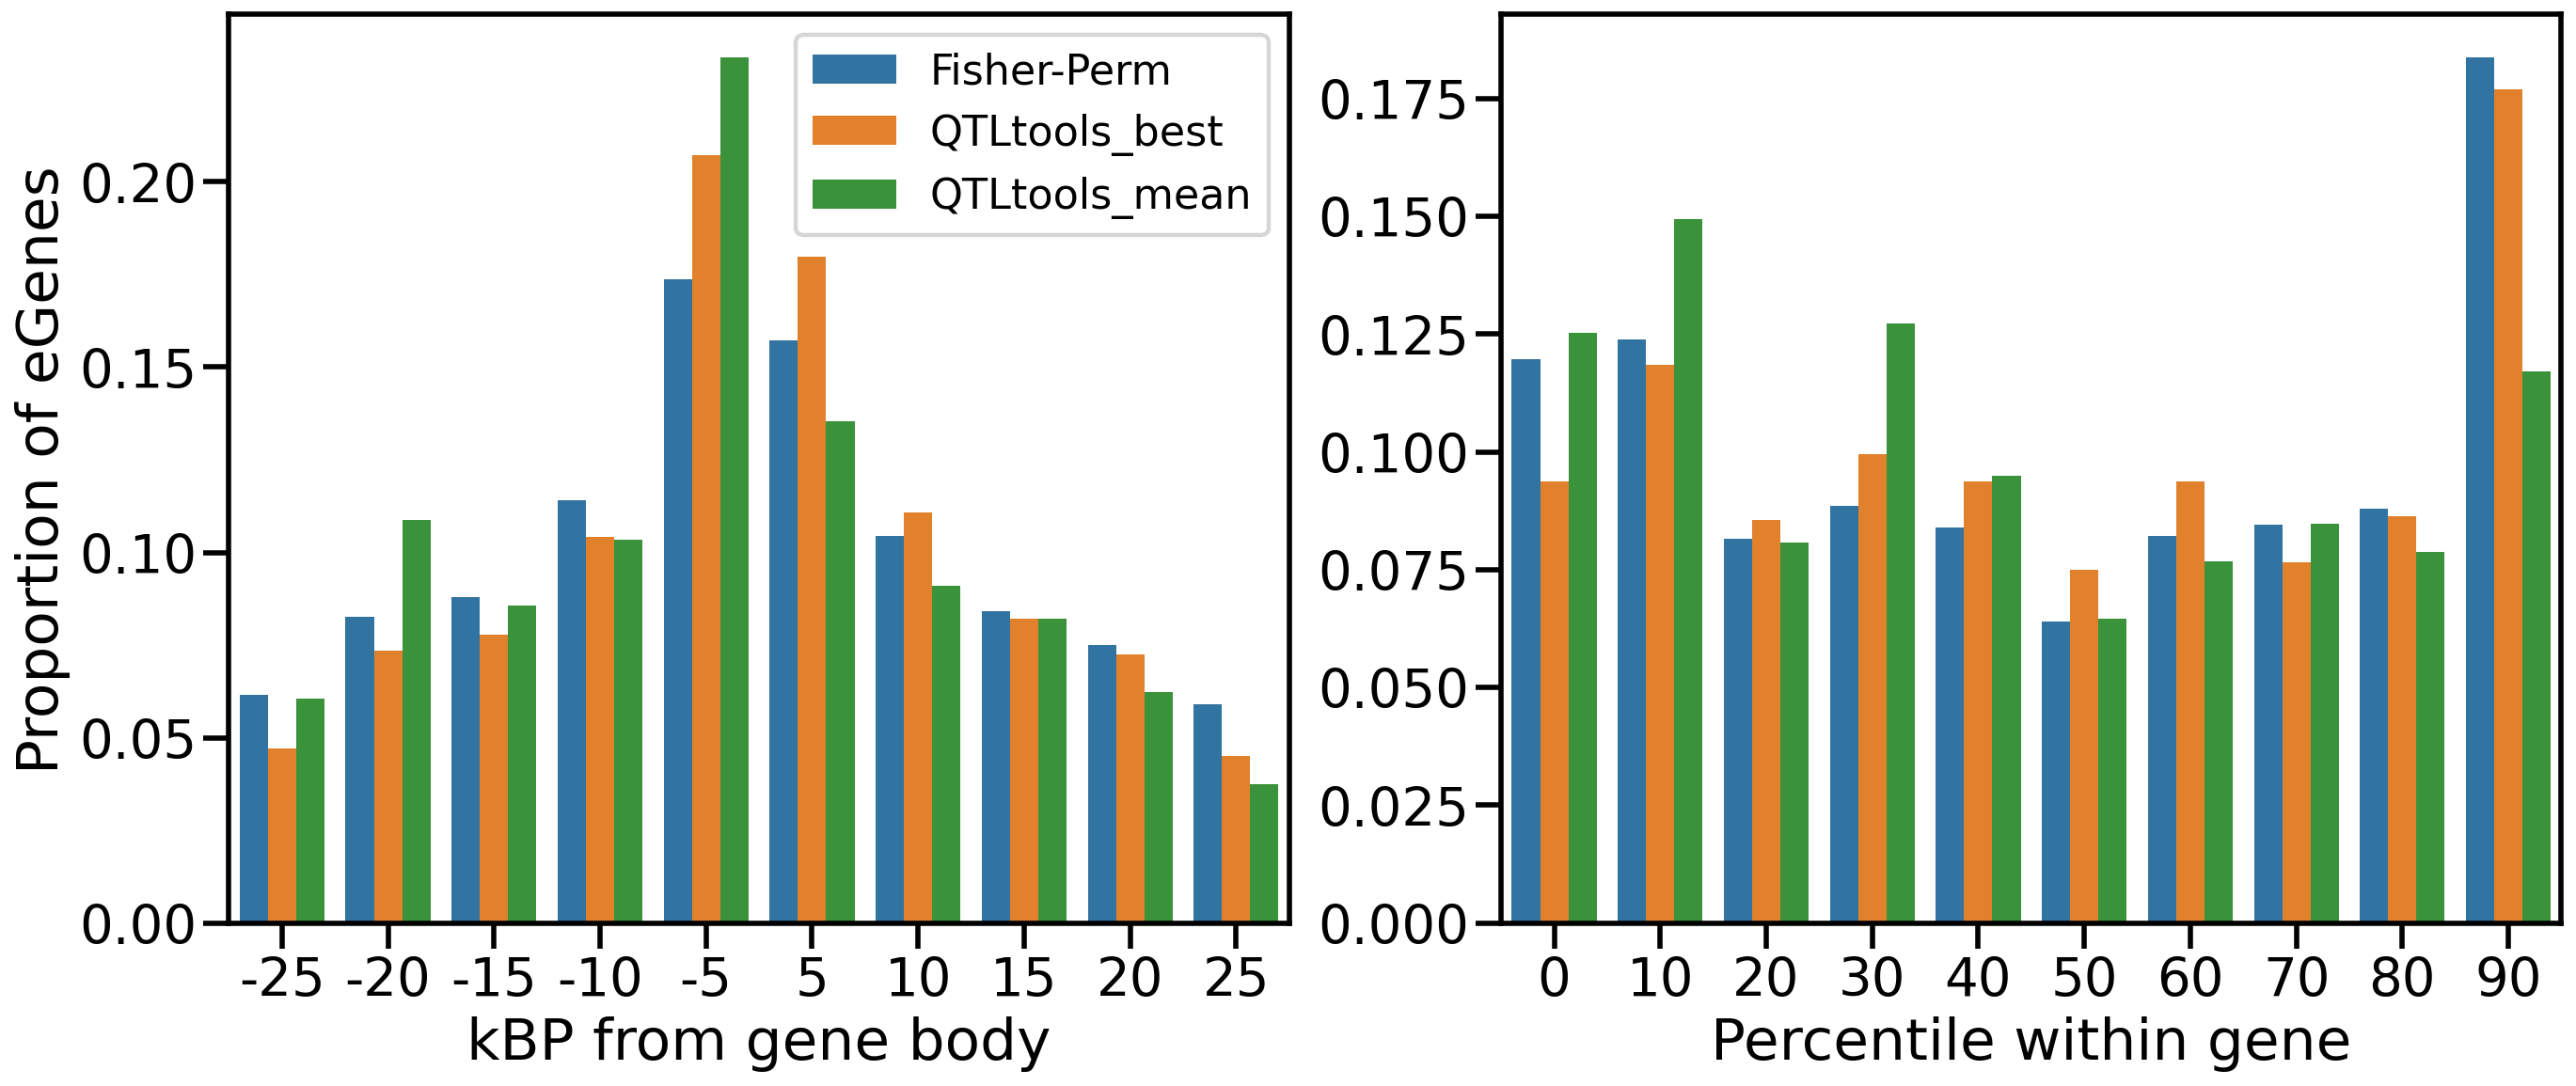

In [31]:
plt.figure(num=None, figsize=(20, 8), dpi=160, facecolor='w', edgecolor='k')
sns.set_context("poster", font_scale=1.15)
if proportional:
    ylab = 'Proportion of eGenes'
else:
    ylab = 'eGenes'

plt.subplot(1,2,1)
ax1 = sns.barplot(data=df_tss, x="kBP from gene body", y=ylab, hue="Method")
plt.legend(prop={'size': 20})
#ax1.set_title('A')

plt.subplot(1,2,2)
ax2 = sns.barplot(data=df_within, x="Percentile within gene", y=ylab, hue="Method")
plt.ylabel("")
ax2.get_legend().remove()
#ax2.set_title('B')

plt.savefig('combined_pos_plot.png')

In [16]:
print(avg_genelen)

29859.1710387704


In [21]:
def get_eqtl_pos_stats(res_fname, snp2pos, gene2loc, gene2exons, gene2strand, method):
    # calculate percentage of eQTLs within 1kb of TSS, within exon, within intron, and outside gene body
    near_tss, in_exon, in_intron, before_gene, after_gene, total = 0, 0, 0, 0, 0, 0
    with(open(res_fname, 'r')) as infile:
        for line in infile:
            splits = line.strip().split(' ')
            if method == 'qtltools_mean':
                gene, rsid = splits[0], splits[8]
            elif method == 'qtltools_best':
                gene, rsid = splits[0], splits[9]
            else:
                gene, rsid = splits[:2]
            gene = gene.split('.')[0]
            gene_start, gene_end = gene2loc[gene]
            reverse_strand = (gene2strand[gene] == '-')
            snp_pos = int(snp2pos[rsid])
            
            # count stats
            total += 1
            if not reverse_strand and abs(snp_pos - gene_start) < 5000:
                near_tss += 1
            elif reverse_strand and abs(snp_pos - gene_end) < 5000:
                near_tss += 1
            if snp_pos >= gene_start and snp_pos <= gene_end:
                exon_tf = False
                for exon_start, exon_end in gene2exons[gene]:
                    if snp_pos >= exon_start and snp_pos <= exon_end:
                        exon_tf = True
                        break
                if exon_tf:
                    in_exon += 1
                else:
                    in_intron += 1
            elif (not reverse_strand and snp_pos < gene_start) or (reverse_strand and snp_pos > gene_end):
                before_gene += 1
            else:
                after_gene += 1
    stats = {}
    stats['Percent of eQTLs near TSS'] = round(near_tss / total * 100, 1)
    stats['Percent of eQTLs in Exons'] = round(in_exon / total* 100, 1)
    stats['Percent of eQTLs in Introns'] = round(in_intron / total * 100, 1)
    stats['Percent of eQTLs before gene'] = round(before_gene / total * 100, 1)
    stats['Percent of eQTLs after gene'] = round(after_gene / total * 100, 1)
    outside_gene = before_gene + after_gene
    within_gene = total - outside_gene
    stats['Percent of eQTLs within gene'] = round(within_gene / total * 100, 1)
    stats['Percent of eQTLs outside gene'] = round(outside_gene / total * 100, 1)
    return stats

In [22]:
fisher_stats = get_eqtl_pos_stats(fisher_res, snp2pos, gene2loc, gene2exons, gene2strand, 'fisher')
for key in fisher_stats:
    print(key + ':  ' + str(fisher_stats[key]))

Percent of eQTLs near TSS:  18.1
Percent of eQTLs in Exons:  10.7
Percent of eQTLs in Introns:  31.6
Percent of eQTLs before gene:  29.8
Percent of eQTLs after gene:  27.9
Percent of eQTLs within gene:  42.4
Percent of eQTLs outside gene:  57.6


In [23]:
qtltools_mean_stats = get_eqtl_pos_stats(
    qtltools_mean_res, snp2pos, gene2loc, gene2exons, gene2strand, 'qtltools_mean')
for key in qtltools_mean_stats:
    print(key + ':  ' + str(qtltools_mean_stats[key]))

Percent of eQTLs near TSS:  24.4
Percent of eQTLs in Exons:  9.6
Percent of eQTLs in Introns:  28.7
Percent of eQTLs before gene:  36.9
Percent of eQTLs after gene:  24.9
Percent of eQTLs within gene:  38.3
Percent of eQTLs outside gene:  61.7


In [24]:
qtltools_best_stats = get_eqtl_pos_stats(
    qtltools_best_res, snp2pos, gene2loc, gene2exons, gene2strand, 'qtltools_best')
for key in qtltools_best_stats:
    print(key + ':  ' + str(qtltools_best_stats[key]))

Percent of eQTLs near TSS:  21.4
Percent of eQTLs in Exons:  15.8
Percent of eQTLs in Introns:  32.2
Percent of eQTLs before gene:  26.9
Percent of eQTLs after gene:  25.1
Percent of eQTLs within gene:  48.0
Percent of eQTLs outside gene:  52.0
